# Modelo de **Hodgkin & Huxley**

Referencias:

1. https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model
2. Eugene M. Izhikevich, Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting, Computational Neuroscience, The MIT Press (2006)
3. https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/How_to_upload_an_image_to_Colab_.ipynb#scrollTo=KKTpNAGCWLeB

## **Ejercicio 1)** Importando librerías

**a)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**b)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [58]:
# 1.a)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [59]:
# 1.b)
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
# import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Teoría y Contexto**

### Las neuronas son capacitores

Según el modelo de Hodgkin y Huxley, a primera vista las neuronas funcionan como capacitores evidenciando una diferencia de potencial eléctrico entre el exterior y el interior debido a las diferentes concentraciones de cargas iónicas que pueden existir entre estas dos regiones.
En el esquema, se utilizan agujas muy finas para inyectar una corriente iónica $i$ al interior de una neurona sumergida en una solución salina conductora.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/esquema1.png?raw=true:, width=100" alt="My Image" width=300>

Recordemos que un capacitor sujeto a una diferencia de potencial $v:=v_A-v_B$ adquiere una carga $q=cv$.
La carga crece según $\dot{q}=i$, donde $i$ denota la corriente de carga eléctrica que va desde el exterior hacia el interior.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito1.png?raw=true:, width=100" alt="My Image" width=500>

### Las neuronas son capacitores con fugas

Si miramos un poco más en detalle, veremos que la membrana de las neuronas tienen canales por donde pueden circular iones.
Podemos pensar a los canales como agujeritos en la membrana por donde la carga se fuga.
En otras palabras, podemos pensar a los canales como a una resistencia conectada en paralelo al capacitor.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito2.png?raw=true:, width=100" alt="My Image" width=500>

La corriente $i_g=g(v_A-v_B)=gv$, donde $i_g$ denota una corriente que va desde el interior hacia el exterior.

### Las neuronas son baterias

Los canales pueden ser selectivos.
Por ejemplo, algunos canales sólo dejan pasar los iones $\mathrm{K}^+$.
Por ende, si inyectamos al interior de la neurona una mezcla de iones $\mathrm{K}^+$ y $\mathrm{Cl}^-$, de manera que la carga total se encuentre equilibrada, los iónes $\mathrm{Cl}^+$ comenzarán a difundir desde el interior hacia el exterior a travéz de los canales selectivos, mientras que los de $\mathrm{Cl}^-$ se quedarán en el interior.
Esto generará un creciente excedente de cargas negativas en el interior y positivas en el exterior, hasta alcanzar un estado de equilibrio en donde la corriente de iones $\mathrm{K}^+$ provocada por la difusión se detiene debido a la diferencia de potencial emergente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/baterias.png?raw=true:, width=100" alt="My Image" width=500>

Este potencial se llama potencial de Nernst o de reversión y se lo incorpora al circuito que modela la neurona como una batería conectada en serie a la resistencia asociada a cada canal

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito3.png?raw=true:, width=100" alt="My Image" width=500>

Ahora, la corriente $i_g=g(v_A-v_C)=g(v_A-(v_B+e_g))=g(v_A-v_B-e_g)=g(v-e_g)=:g(v-v_g)$, donde en la última iguadad reconocemos la definición del potencial de Nernst $v_g$.

Si la batería se encuentra en sentido inverso

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito4.png?raw=true:, width=100" alt="My Image" width=500>

entonces $i_g=g(v_A-v_C)=g(v_A-(v_B-e_g))=g(v_A-v_B+e_g)=g(v+e_g)=:g(v-v_g)$, por lo que el potencial de Nernst resulta negativo, $v_g=-e_g$.

### Algunos canales forman reóstatos (resistencias de conductancia variable)

Algunos canales tienen compuertas que se abren o cierran, permitiendo o impidiendo el paso de iones, respectivamente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/compuertas.png?raw=true:, width=100" alt="My Image" width=500>

La conductividad asociada a estos canales, depende de la fracción de compuertas abiertas en cada tipo de canal.
Según el modelo, la conductancia total asociada a los canales de $\mathrm{Na}$ se aproxima por

$$g_{\mathrm{Na}} = \bar{g}_{\mathrm{Na}}p_{\mathrm{Na}}$$

donde $\bar{g}_{\mathrm{Na}}$ es la conductancia de $\mathrm{Na}$ máxima posible y

$$p_{\mathrm{Na}} = m^3h$$

es la fracción de canales de $\mathrm{Na}$ abiertos.
Aquí $m$ y $h$ son la fracciones de compuertas abiertas de activación e inactivación, respectivamente.
Los canales de $\mathrm{Na}$ poseen 3 compuertas de activación y 1 de inactivación, por lo que $m$ tiene un exponente 3 y $h$ un exponente 1.

De manera similar, la conductancia asociada a los canales de $\mathrm{K}$ se aproxima por

$$g_{\mathrm{K}} = \bar{g}_{\mathrm{K}}p_{\mathrm{K}}$$

donde $\bar{g}_{\mathrm{K}}$ es la conductancia de $\mathrm{K}$ máxima posible,

$$p_{\mathrm{K}} = n^4$$

es la fracción de canales de $\mathrm{K}$ abiertos y $n$ es la fracción de compuertas abiertas en este tipo de canales.
Cada canal de $\mathrm{K}$ posee 4 compuertas de tipo $n$, de ahí el exponente 4.

Estas aproximaciones asumen que las compuertas abren o cierran de manera independiente, dependiendo de la diferencia de potencial de membrana existente $v$.
Más precisamente, las fracciones de compuertas abiertas de cada tipo satisfacen

\begin{eqnarray}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h
\end{eqnarray}

donde

\begin{eqnarray}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{eqnarray}

representan las tasas a las cuales las compuertas cerradas de cada tipo abren y

\begin{eqnarray}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{eqnarray}

representan las tasas a las cuales las compuertas abiertas de cada tipo cierran, respectivamente.

En resumen, al modelo de neurona de Hodgkin y Huxley se lo puede representar por el circuito

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito5.png?raw=true:, width=100" alt="My Image" width=500>

en donde reconocemos la existencia de 3 canales iónicos: uno de pérdida (leak) de conductancia constante $g_l$, potencial de Nernst $v_l=e_l$ y por el que fluye una corriente $i_l$, uno de $\mathrm{Na}$ de conductancia variable $g_{\mathrm{Na}}$, potencial de Nernst $v_{\mathrm{Na}}=e_{\mathrm{Na}}$ y por el que fluye una corriente $i_{\mathrm{Na}}$, y uno de $\mathrm{K}$ de conductancia $g_{\mathrm{K}}$, potencial de Nernst $v_{\mathrm{K}}=-e_{\mathrm{K}}$ y por el que fluye una corriente $i_{\mathrm{K}}$.

Aplicando la ley de Kirchoff para corrientes, vemos que

$$i=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l+i_c$$

Es decir, la corriente $i$ inyectada al interior de la neurona se divide en dos partes.
Por un lado, en la corriente $i_m=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l$ que fluye a travéz de los canales en la membrana,
y por otro lado, en la corriente $i_c$ que carga el capacitor.

Remplazando, obtenemos una ODE para el potencial de membrana

\begin{eqnarray}
i_c&=&i-i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l\\
c\dot{v}&=&i-g_{\mathrm{Na}}(v-v_{\mathrm{Na}})-g_{\mathrm{K}}(v-v_{\mathrm{K}})-g_{l}(v-v_{l})\\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{eqnarray}

La última línea de la anterior ecuación, junto con las ODEs anteriormente mencionadas para $n$, $m$ y $h$, determinan el sistema de ODEs del modelo de Hodgkin y Huxley.

### Comportamiento cualitativo

Durante el proceso de disparo, diferentes compuertas se abren y cierran a diferentes tiempos.
El siguiente esquema resume el proceso en 4 etapas

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/channels.png?raw=true:, width=100" alt="My Image" width=300>

Estimaciones de los tiempos carácterísticos y valores de equilibrio del comportamiento de las compuertas observado en las diferentes etapas se pueden obtener de reescribir las ODEs para $n$, $m$ y $h$ de la forma

\begin{eqnarray}
\dot{n}&=&\tau_n^{-1}(v)(n_{\infty}(v)-n)\\
\dot{m}&=&\tau_m^{-1}(v)(m_{\infty}(v)-m)\\
\dot{h}&=&\tau_h^{-1}(v)(h_{\infty}(v)-h)
\end{eqnarray}

donde

\begin{eqnarray}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{eqnarray}

y

\begin{eqnarray}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{eqnarray}

Finalmente, listamos los valores de los parámetros del modelo (ver libro de Izhikevich)

* $c=1\,\mu F/cm^2$ : capacitancia de membrana
* $\bar{g}_{\mathrm{Na}}=120\,mS/cm^2$ : conductancia máxima de $\mathrm{Na}$
* $\bar{g}_{\mathrm{K}}=36\,mS/cm^2$ : conductancia máxima de $\mathrm{K}$
* $g_l=0.3\,mS/cm^2$ : conductancia máxima de perdida
* $v_{\mathrm{Na}}=120\,mV$ : potencial de reversión de la corriente de $\mathrm{Na}$
* $v_{\mathrm{K}}=-12\,mV$ : potencial de reversión de la corriente de $\mathrm{K}$
* $v_l=10.6\,mV$ : potencial de reversión de la corriente de perdida
* $i(t)\sim 10\,\mu A/cm^2$ : corriente de entrada al tiempo $t$
* $t \sim 5\,ms$ : tiempo

Aclaración, los valores de los potenciales de Nernst se toman en referencia al potencial de equilibrio definido en $v\approx 0\, mV$.

In [60]:
# Dejamos definidas las constantes para usarlas a lo largo del código
c    = 1
g_Na = 120
g_K  = 32
g_l  = 0.3
v_Na = 120
v_K  = -12
v_l  = 10.6

## Ejercicio 2) implementación

**1)** Usando la sección de teoría y las referencias, implemente el modelo de Hodgkin y Huxley el integrador numérico de ODEs tipo Runge-Kutta de orden 4 del práctico 4.

Traemos todas las ecuaciones acá para tenerlas más cerca:

\begin{eqnarray}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{eqnarray}

representan las tasas a las cuales las compuertas cerradas de cada tipo abren y

\begin{eqnarray}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{eqnarray}

representan las tasas a las cuales las compuertas abiertas de cada tipo cierran, respectivamente.

Y por otro lado, tenemos:
\begin{eqnarray}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{eqnarray}

y

\begin{eqnarray}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{eqnarray}

In [61]:
alpha_h = lambda v: 0.07 * np.exp(-v/20)
alpha_m = lambda v: 0.1  * ((25-v) / ((np.exp((25-v)/10)) - 1))
alpha_n = lambda v: 0.01 * ((10-v) / ((np.exp((10-v)/10)) - 1))

beta_h = lambda v: 1 / (np.exp((30-v)/10) + 1)
beta_m = lambda v: 4 * np.exp(-v/18)
beta_n = lambda v: 0.125 * np.exp(-v/80)

tau_h = lambda v: 1/(alpha_h(v) + beta_h(v))
tau_m = lambda v: 1/(alpha_m(v) + beta_m(v))
tau_n = lambda v: 1/(alpha_n(v) + beta_n(v))

h_inf = lambda v: tau_h(v)*alpha_h(v)
m_inf = lambda v: tau_m(v)*alpha_m(v)
n_inf = lambda v: tau_n(v)*alpha_n(v)

\begin{eqnarray}
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{eqnarray}

In [62]:
def i_na(x, p):
  v = x[0]
  m = x[2]
  h = x[3]

  return g_Na * (v-v_Na) * (m**3) * h

def i_k(x, p):
  v = x[0]
  n = x[1]

  return g_K * (v-v_K) * (n**4)

def i_l(x, p):
  v = x[0]

  return g_l * (v-v_l)

\begin{eqnarray}
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))\\
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h
\end{eqnarray}

In [63]:
'''
    v = x[0]
    n = x[1]
    m = x[2]
    h = x[3]

    i = p[0]
'''

def v_(x, t, p):
    v = x[0]
    n = x[1]
    m = x[2]
    h = x[3]
    i = p[0]
    return (i(t) - i_na(x,p) - i_k(x,p) - i_l(x,p))/c

def n_(x, t, p):
    v = x[0]
    n = x[1]
    return alpha_n(v)*(1-n) - beta_n(v)*n

def m_(x, t, p):
    v = x[0]
    m = x[2]
    return alpha_m(v)*(1-m) - beta_m(v)*m

def h_(x, t, p):
    v = x[0]
    h = x[3]
    return alpha_h(v)*(1-h) - beta_h(v)*h

f = lambda x, t, p: np.array([
    v_(x, t, p),
    n_(x, t, p),
    m_(x, t, p),
    h_(x, t, p)
])

In [64]:
r0 = np.array([0, 0, 0, 0])

i = lambda t: 10
params = np.array([i])

a = 0
b = 10
h = 0.01
k = int((b-a)/h)

In [65]:
t, w = integrador_ode(rk4, f, r0, a, b, k, params)

**2)** Grafique los valores de equilibrio de las distintas fracciones de canales activados $n_{\infty}$, $m_{\infty}$ e inactivados $h_{\infty}$, en función de la diferencia de potencial de membrana $v$.

\begin{eqnarray}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{eqnarray}

y

\begin{eqnarray}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{eqnarray}

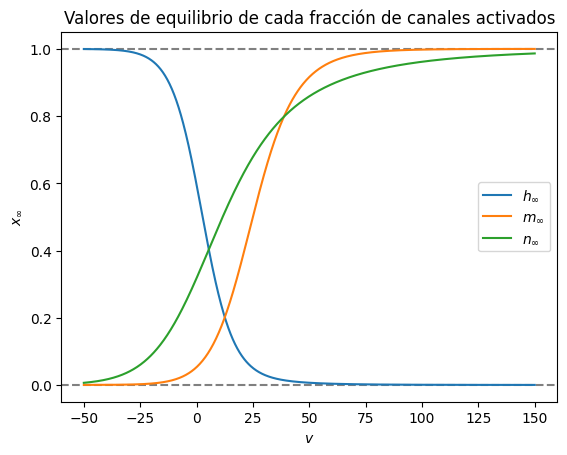

In [66]:
vs = np.linspace(-50,150,1000)
hs = h_inf(vs)
ms = m_inf(vs)
ns = n_inf(vs)

plt.xlabel('$v$')
plt.ylabel('$x_{\\infty}$')
plt.plot(vs, hs,label='$h_{\\infty}$')
plt.plot(vs, ms,label='$m_{\\infty}$')
plt.plot(vs, ns,label='$n_{\\infty}$')
plt.axhline(0, color='grey', linestyle='--', zorder=-5)
plt.axhline(1, color='grey', linestyle='--', zorder=-5)
plt.title("Valores de equilibrio de cada fracción de canales activados")
plt.legend()
plt.show()

**3)** Grafique los tiempos característicos de activación $\tau_m$, $\tau_n$ e inactivación $\tau_h$ asociados a los distintos tipos de canales, en función de la diferencia de potencial de membrana $v$.

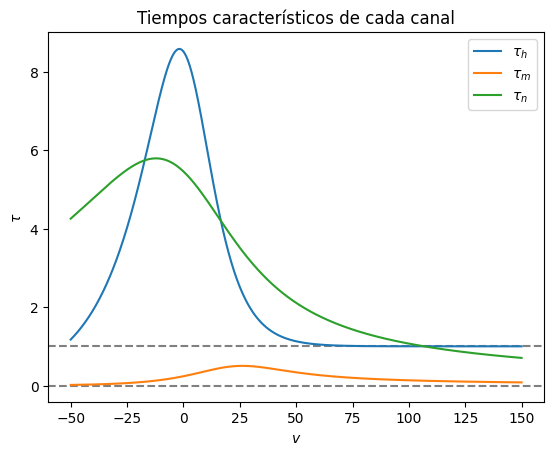

In [67]:
tau_hs = tau_h(vs)
tau_ms = tau_m(vs)
tau_ns = tau_n(vs)

plt.xlabel('$v$')
plt.ylabel('$\\tau$')
plt.plot(vs, tau_hs, label='$\\tau_{h}$')
plt.plot(vs, tau_ms, label='$\\tau_{m}$')
plt.plot(vs, tau_ns, label='$\\tau_{n}$')
plt.axhline(0, color='grey', linestyle='--', zorder=-5)
plt.axhline(1, color='grey', linestyle='--', zorder=-5)
plt.title("Tiempos característicos de cada canal")
plt.legend()
plt.show()

## Ejercicio 3) valores de equilibrio

**1)** Integre el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a una corriente total $i(t)=0$ para todo $t$. Use la condición inicial $v_0=0mV$, $n_0=m_0=h_0=0$ y $t_0=0ms$. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.


In [68]:
# En orden, tenemos: v n m h
r0 = np.array([0, 0, 0, 0])

i = lambda t: 0
params = np.array([i])

a = 0
b = 500
h = 0.01
k = int((b-a)/h)

In [69]:
t, w = integrador_ode(rk4, f, r0, a, b, k, params)

**2)** Grafique el potencial de membrana en función del tiempo, i.e. grafique $v(t)$ vs $t$ en el rango calculado.

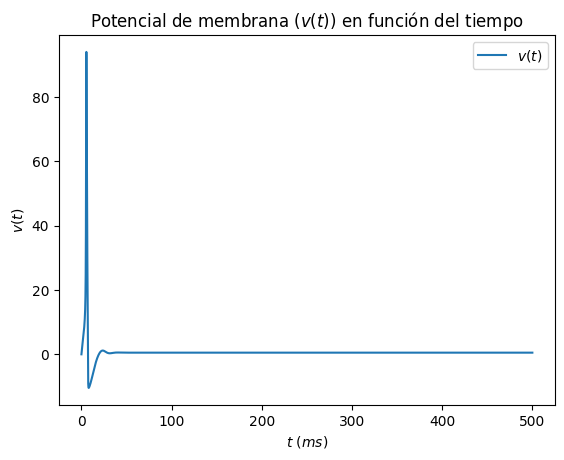

In [70]:
vs = w[0, :]

plt.xlabel('$t\ (ms)$')
plt.ylabel('$v(t)$')
plt.plot(t, vs, label='$v(t)$')
plt.title("Potencial de membrana ($v(t)$) en función del tiempo")
plt.legend()
plt.show()

**3)** Grafique las diferentes corrientes de iones cruzando la membrana en función del tiempo, i.e. grafique  la corriente de iones de sodio $i_{Na}(t)$, la corriente de iones de potasio $i_K(t)$ y la corriente de pérdida $i_l(t)$ vs $t$ en el rango calculado.

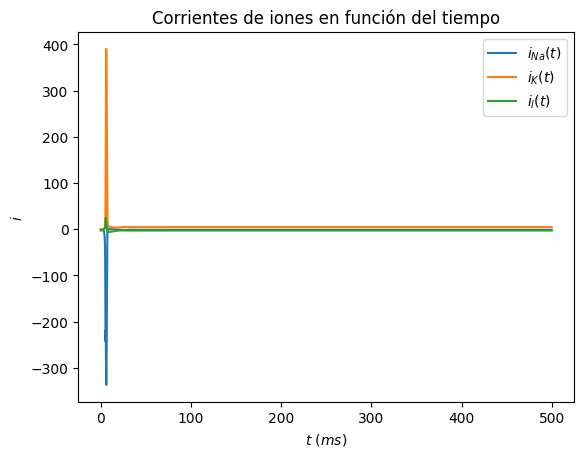

In [71]:
i_nas = i_na(w, params)
i_ks  = i_k (w, params)
i_ls  = i_l (w, params)

plt.xlabel('$t\ (ms)$')
plt.ylabel('$i$')
plt.plot(t, i_nas, label='$i_{Na}(t)$')
plt.plot(t, i_ks,  label='$i_{K}(t)$')
plt.plot(t, i_ls,  label='$i_{l}(t)$')
plt.title("Corrientes de iones en función del tiempo")
plt.legend()
plt.show()

**4)** Grafique las fracción de canales activados e inactivados de cada tipo en función del tiempo, i.e. grafique $n(t)$ (fracción de canales de potasio $K$ activos), $m(t)$ (fracción de canales de sodio $Na$ activos) y $h(t)$ (fracción de canales de sodio $Na$ inactivos) vs $t$ en el rango calculado.

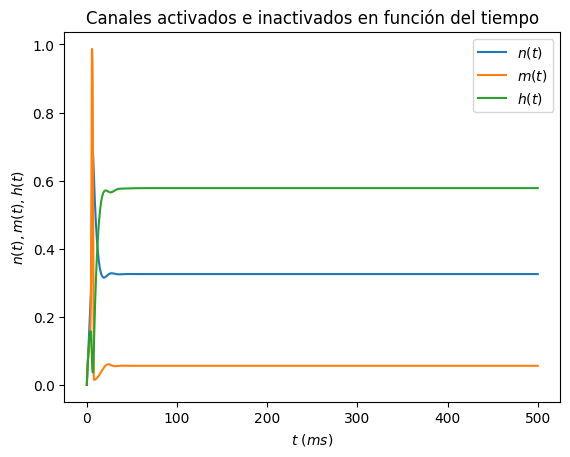

In [72]:
ns = w[1, :]
ms = w[2, :]
hs = w[3, :]

plt.xlabel('$t\ (ms)$')
plt.ylabel('$n(t), m(t), h(t)$')
plt.plot(t, ns, label='$n(t)$')
plt.plot(t, ms, label='$m(t)$')
plt.plot(t, hs, label='$h(t)$')
plt.title("Canales activados e inactivados en función del tiempo")
plt.legend()
plt.show()

**5)** Almacene los valores de equilibrio a corriente nula de las variables dinámicas usando los valores de las mismas obtenidos a tiempos largos. Es decir, almacene los valores $v^* \approx v(t_f)$, $n^* \approx n(t_f)$, $m^* \approx m(t_f)$ y $h^* \approx h(t_f)$, para ser utilizado como condiciones iniciales en futuras integraciones de las ODEs del modelo de Hodgkin y Huxley.

In [73]:
v_equilibrio = w[0, -1]
n_equilibrio = w[1, -1]
m_equilibrio = w[2, -1]
h_equilibrio = w[3, -1]

print(f"Valor de equilibrio a corriente nula de v(t): {v_equilibrio}")
print(f"Valor de equilibrio a corriente nula de n(t): {n_equilibrio}")
print(f"Valor de equilibrio a corriente nula de m(t): {m_equilibrio}")
print(f"Valor de equilibrio a corriente nula de h(t): {h_equilibrio}")

Valor de equilibrio a corriente nula de v(t): 0.51356787690768
Valor de equilibrio a corriente nula de n(t): 0.32557554637412073
Valor de equilibrio a corriente nula de m(t): 0.056226515128559605
Valor de equilibrio a corriente nula de h(t): 0.5780535944733723


## Ejercicio 4) estímulo débil y estímulo fuerte

**1)** Implemente una función de corriente de entrada o membrana dada por:

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [2ms,2.5ms] \\
30 \mu A/cm^2, & t\in [10ms,10.5ms] \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Aquí, $c.c.$ indica *en caso contrario*. Esta corriente representa un estímulo débil seguido de uno fuerte. Grafíque la corriente $i(t)$ vs $t$ en el rango $t\in[0ms,20ms]$.

In [74]:
def i(t):
    if 2 <= t <= 2.5:
        return 10
    elif 10 <= t <= 10.5:
        return 30
    return 0

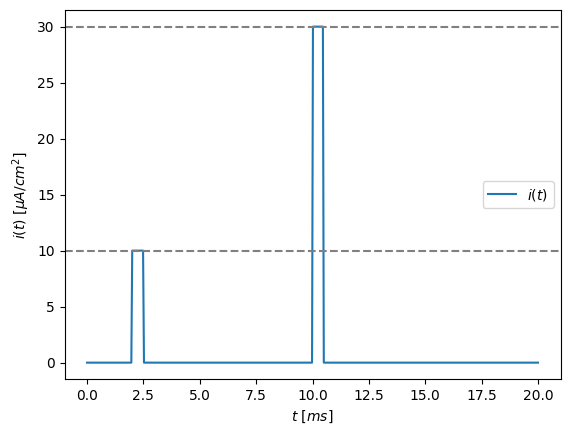

In [75]:
t = np.linspace(0, 20, 500)

plt.plot(t, [i(ti) for ti in t], label="$i(t)$")
plt.xlabel("$t\ [ms]$")
plt.ylabel("$i(t)\ [\mu A/cm^2]$")
plt.axhline(10, color='grey', linestyle='--')
plt.axhline(30, color='grey', linestyle='--')
plt.legend()
plt.show()

**2)** Integre nuevamente el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a la corriente del inciso anterior. Use como condición inicial a tiempo $t=0$ los valores de equilibrio estimados en el ejercicio anterior. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

**3)** Grafique el potencial de membrana en función del tiempo, i.e. $v(t)$ vs $t$ en el rango calculado.

**4)** Grafique la evolución de las fraciones de canales activos e inactivos, $n(t)$, $m(t)$ y $h(t)$ vs $t$.

**5)** Discuta como responde la neurona en el primer impulso a $t=2ms$. Luego, como responde al segundo impulso a $t=10ms$. Existe una diferencia? Explique.

In [76]:
# 4.1)

## Ejercicio 5) ráfaga

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [5ms,\infty ms) \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Esta corriente representa un estímulo constante.

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando como condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [77]:
# 5.1)

## Ejercicio 6) período refractario

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [10ms\, k,10 ms\, k + 2ms], k \in \{1,2,3,4,5,...\}\\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

In [78]:
# TODO: Remover valores de equilibrio una vez pusheado ej3
n_e = 0.3183527383438073
m_e = 0.05319833491998101
h_e = 0.5938510049701359
v_e = 0.04274478930271925

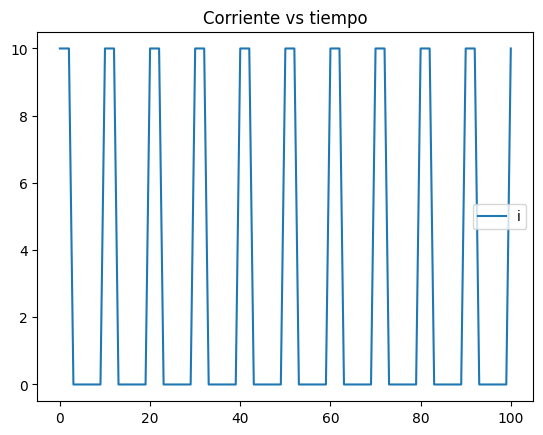

In [79]:
# 6.1)
def i6(t):
  return 10 if int(t) % 10 in [0, 1] or (t % 10 == 2 and t == int(t)) else 0

ts = np.linspace(0, 100, 101)
plt.plot(ts, [i6(t) for t in ts], label="i")
plt.title("Corriente vs tiempo")
plt.legend()

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando la corriente del inciso **12)**, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

In [80]:
a = 0
b = 100
h = 0.01
k = int((b-a)/h)

params = np.array([i6])

xa = np.array([v_e, n_e, m_e, h_e])
t,w = integrador_ode(rk4, f, xa, a, b, k, params)

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

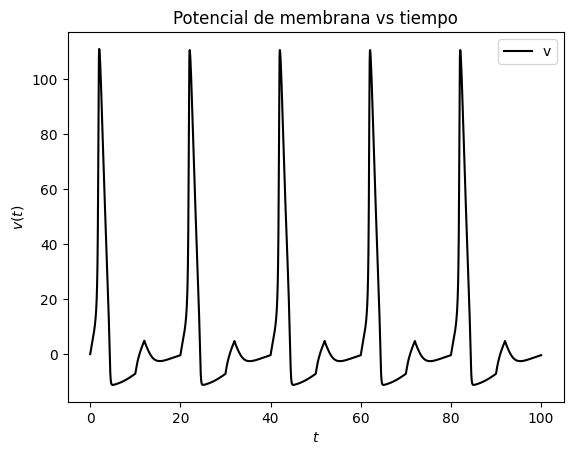

In [81]:
# 3.1)
plt.xlabel('$t$')
plt.ylabel('$v(t)$')
plt.plot(t,w[0,:],label="v",color='black')
plt.title('Potencial de membrana vs tiempo')
plt.legend()

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

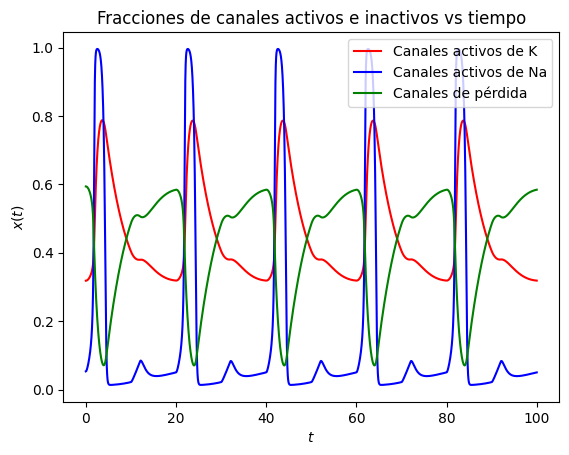

In [82]:
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.plot(t,w[1,:],label="Canales activos de K",color='red')
plt.plot(t,w[2,:],label="Canales activos de Na",color='blue')
plt.plot(t,w[3,:],label="Canales de pérdida",color='green')
plt.title('Fracciones de canales activos e inactivos vs tiempo')
plt.legend()

**5)** Discuta lo que observa y explique.

In [83]:
# 6.1)

## Ejercicio 7) exitaciones espontáneas en respuesta al ruido

**1)** Implemente una corriente estocástica que retorne un valor $i(t)\sim i_0 N(0,1)$ (i.e. $i_0$ por un valor aleatorio obtenido de una distribución normal de media 0 y varianza 1) para cada valor de $t$ en el que sea evaluada.

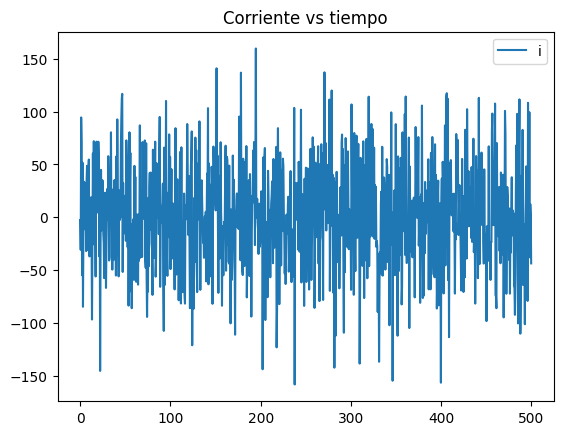

In [84]:
# 7.1)
def i7(t, i0=50):
  return i0*np.random.normal(loc=0, scale=1)

ts = np.linspace(0, 500, 1000)
plt.plot(ts, [i7(t) for t in ts], label="i")
plt.title("Corriente vs tiempo")
plt.legend()

**2)** Integre nuevamente las ODEs para $t\in[0ms,500ms]$, usando la corriente del inciso **22)** para $i_0=50\mu A$, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

In [85]:
a=0
b=500
h=0.01
k = int((b-a)/h)
xa = np.array([v_e, n_e, m_e, h_e])

params = np.array([i7])

t,w = integrador_ode(rk4, f, xa, a, b, k, params)

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

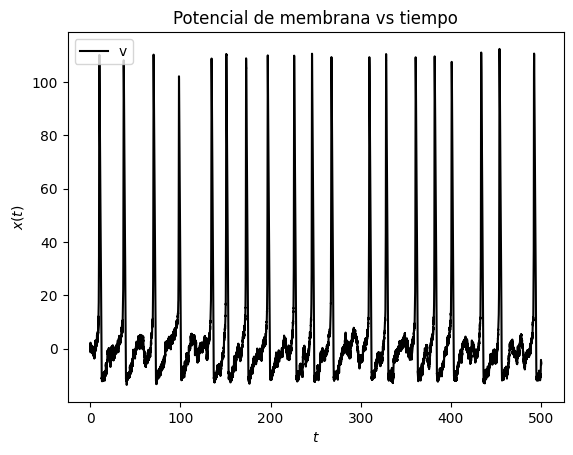

In [86]:
# 3.1)
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.plot(t,w[0,:],label="v",color='black')
plt.title('Potencial de membrana vs tiempo')
plt.legend()

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

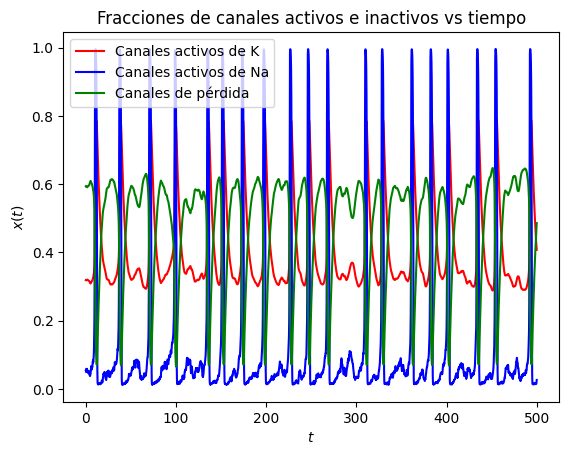

In [87]:
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.plot(t,w[1,:],label="Canales activos de K",color='red')
plt.plot(t,w[2,:],label="Canales activos de Na",color='blue')
plt.plot(t,w[3,:],label="Canales de pérdida",color='green')
plt.title('Fracciones de canales activos e inactivos vs tiempo')
plt.legend()

**5)** Observa picos de activación cada tanto? Aparecen con regularidad? Estime con que frecuencia observa los picos.

# **Notas**